Lambda School Data Science

*Unit 4, Sprint 1, Module 4*

---

# Topic Modeling (Prepare)

# Latent Dirchilet Allocation (LDA) Models (Prepare)
<a id="#p1"></a>

## Overview
LDA is a "generative probabilistic model". 

Let's play with a modoel available [here](https://lettier.com/projects/lda-topic-modeling/)

## Follow Along

## Challenge 

---
---

# Estimating LDA Models with Gensim (Learn)
<a id="#p1"></a>

## Overview
### A Litterary Introduction: *Jane Austen V. Charlotte Bronte*
Despite being born nearly forty years apart, modern fans often pit Jane Austen & Charlotte Bronte against one another in a battle for litterary  supremacy. The battle centers around the topics of education for women, courting, and marriage. The authors' similiar backgrounds naturally draw comparisons, but the modern fascination is probably due to novelility of British women publishing novels during the early 19th century. 

Can we help close a litterary battle for supremacy and simply acknowledge that the authors addressed different topics and deserve to be acknowledged as excellent authors each in their own right?

We're going to apply Latent Dirichlet Allocation a machine learning alogrithm for topic modeling to each of the author's novels to compare the distribution of topics in their novels.

In [1]:
import numpy as np
import gensim
import os
import re

from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora

from gensim.models.ldamulticore import LdaMulticore

import pandas as pd

## Follow Along

### Novel Data
I grabbed the novel data pre-split into a bunch of smaller chuncks

In [2]:
path = './data/austen-brontë-split'

In [4]:
STOPWORDS = set(STOPWORDS).union(set(['said', 'mr', 'mrs']))

def tokenize(text):
    return [token for token in simple_preprocess(text) if token not in STOPWORDS]

In [ ]:
for f in os.listdir(path):
    if os.path.splitext(f)[1] == ".txt":
        print(f)

In [21]:
import os

def gather_data(path_to_data): 
    data = []
    
    for f in os.listdir(path):
        if os.path.isdir(f) == False:
            if os.path.splitext(f)[1] == ".txt":
                with open(os.path.join(path,f)) as t:
                    text = t.read().strip('\n')
                    data.append(tokenize(str(text)))
            
    return data

### Text Preprocessing
**Challenge**: update the function `tokenize` with any technique you have learned so far this week. 

In [22]:
# Create tokens from gathered data
tokens = gather_data(path)

In [23]:
# Check them out
tokens[0][:10]

['giving',
 'fair',
 'companion',
 'account',
 'yesterday',
 'party',
 'friend',
 'cole',
 'come',
 'stilton']

In [24]:
titles = [t[:-4] for t in os.listdir(path)]

In [25]:
len(titles)

813

In [26]:
len(tokens)

813

In [27]:
titles[:5]

['Austen_Emma0026',
 'Austen_Emma0032',
 'CBronte_Villette0086',
 'CBronte_Jane0099',
 'CBronte_Villette0092']

### Author DataFrame


In [28]:
df = pd.DataFrame(index=titles, data={"tokens": tokens})

In [29]:
df.head()

,tokens
Austen_Emma0026,"[giving, fair, companion, account, yesterday, ..."
Austen_Emma0032,"[feels, like, snow, place, party, try, day, di..."
CBronte_Villette0086,"[pierced, opaque, blackness, stood, bougie, qu..."
CBronte_Jane0099,"[joke, queer, looks, tell, thing, specially, s..."
CBronte_Villette0092,"[second, landing, floor, comprising, abode, kn..."


In [30]:
# Hydrating the dataframe
df['author'] = df.reset_index()['index'].apply(lambda x: x.split('_')[0]).tolist()
df['book'] = df.reset_index()['index'].apply(lambda x: x.split('_')[1][:-4]).tolist()
df['section'] = df.reset_index()['index'].apply(lambda x: x[-4:]).tolist()
df['section'] = df['section'].astype('int')

In [31]:
df['author'] = df['author'].map({'Austen':1, 'CBronte':0})

In [89]:
df.head()

,tokens,author,book,section
Austen_Emma0026,"[giving, fair, companion, account, yesterday, ...",1,Emma,26
Austen_Emma0032,"[feels, like, snow, place, party, try, day, di...",1,Emma,32
CBronte_Villette0086,"[pierced, opaque, blackness, stood, bougie, qu...",0,Villette,86
CBronte_Jane0099,"[joke, queer, looks, tell, thing, specially, s...",0,Jane,99
CBronte_Villette0092,"[second, landing, floor, comprising, abode, kn...",0,Villette,92


In [32]:
df.author.value_counts()

0    441
1    372
Name: author, dtype: int64

In [33]:
df['tokens'].head()

Austen_Emma0026         [giving, fair, companion, account, yesterday, ...
Austen_Emma0032         [feels, like, snow, place, party, try, day, di...
CBronte_Villette0086    [pierced, opaque, blackness, stood, bougie, qu...
CBronte_Jane0099        [joke, queer, looks, tell, thing, specially, s...
CBronte_Villette0092    [second, landing, floor, comprising, abode, kn...
Name: tokens, dtype: object

### Streaming Documents
Here we use a new pythonic thingy: the `yield` statement in our function. This allows us to iterate over a bunch of documents without actually reading them into memory. You can see how we use this fucntion later on. 

In [34]:
def doc_stream(path):
    for f in os.listdir(path):
        if os.path.isdir(f) == False:
            if os.path.splitext(f)[1] == ".txt":
                with open(os.path.join(path,f)) as t:
                    text = t.read().strip('\n')
                    tokens = tokenize(str(text))
                yield tokens

In [35]:
streaming_data = doc_stream(path)

In [ ]:
# Generator yields one document at a time
next(streaming_data)

### Gensim LDA Topic Modeling

In [55]:
# A Dictionary Representation of all the words in our corpus
id2word = corpora.Dictionary(doc_stream(path))

In [39]:
id2word.token2id['england']

869

In [40]:
id2word[890]

'form'

In [41]:
# Doc to bag of words
id2word.doc2bow(tokenize("This is a sample message Darcy England England England"))

[(869, 3), (1254, 1), (2485, 1), (16851, 1)]

In [42]:
import sys
sys.getsizeof(id2word)  # The id2word dictionary is tiny - 64bytes

64

In [43]:
# Pretty good for how big the vocabulary of the dictionary is
len(id2word.keys())

22096

In [56]:
# Let's remove extreme values from the dataset
id2word.filter_extremes(no_below=5, no_above=0.95)

In [57]:
# Extremes have been filtered
len(id2word.keys())

8103

In [58]:
# A bag of words(bow) representation of our corpus
# Note: we haven't actually read any text into memory here
corpus = [id2word.doc2bow(text) for text in doc_stream(path)]

In [59]:
corpus[0][:10]

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 2),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 2),
 (8, 1),
 (9, 1)]

In [60]:
lda = LdaMulticore(corpus=corpus,
                   id2word=id2word,
                   random_state=92,
                   num_topics = 15,
                   passes=10,
                   workers=4
                  )

In [61]:
lda.print_topics()

[(0,
  '0.013*"emma" + 0.009*"think" + 0.008*"frank" + 0.008*"weston" + 0.007*"churchill" + 0.007*"knightley" + 0.007*"know" + 0.006*"little" + 0.006*"miss" + 0.006*"thing"'),
 (1,
  '0.004*"hunsden" + 0.004*"house" + 0.004*"like" + 0.004*"came" + 0.003*"little" + 0.003*"room" + 0.003*"asked" + 0.003*"night" + 0.003*"round" + 0.003*"thought"'),
 (2,
  '0.007*"jane" + 0.006*"love" + 0.005*"like" + 0.005*"heart" + 0.005*"thought" + 0.004*"little" + 0.004*"know" + 0.004*"good" + 0.003*"man" + 0.003*"saw"'),
 (3,
  '0.008*"like" + 0.006*"john" + 0.005*"know" + 0.004*"good" + 0.004*"little" + 0.004*"think" + 0.004*"thought" + 0.004*"man" + 0.003*"st" + 0.003*"life"'),
 (4,
  '0.003*"released" + 0.003*"comparisons" + 0.003*"foolish" + 0.003*"unnatural" + 0.003*"nineteen" + 0.002*"release" + 0.002*"lovers" + 0.002*"profession" + 0.002*"longstaple" + 0.002*"eighteen"'),
 (5,
  '0.008*"little" + 0.006*"like" + 0.004*"door" + 0.004*"long" + 0.004*"eyes" + 0.004*"saw" + 0.004*"room" + 0.004*"time

In [62]:
# Remove stuff before asterisk
words = [re.findall(r'"([^"]*)"',t[1]) for t in lda.print_topics()]

In [63]:
topics = [' '.join(t[0:5]) for t in words]

In [66]:
for id, t in enumerate(topics): 
    print(f"====== Topic {id} ======")
    print(t)
    print()

====== Topic 0 ======
emma think frank weston churchill

====== Topic 1 ======
hunsden house like came little

====== Topic 2 ======
jane love like heart thought

====== Topic 3 ======
like john know good little

====== Topic 4 ======
released comparisons foolish unnatural nineteen

====== Topic 5 ======
little like door long eyes

====== Topic 6 ======
elinor miss marianne know sister

====== Topic 7 ======
harriet good emma man think

====== Topic 8 ======
little bretton like child know

====== Topic 9 ======
jane rochester know shall like

====== Topic 10 ======
rochester sir room jane like

====== Topic 11 ======
little like thought time day

====== Topic 12 ======
elizabeth darcy bennet bingley jane

====== Topic 13 ======
emma harriet elton weston knightley

====== Topic 14 ======
madame little vous room thought



## Challenge 

You will apply an LDA model to a customer review dataset to practice the fitting and estimation of LDA. 

---
---

# Interpret LDA Results (Learn)
<a id="#p3"></a>

## Overview

## Follow Along

### Topic Distance Visualization

In [67]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

In [68]:
pyLDAvis.gensim.prepare(lda, corpus, id2word)

/Users/Tobias/.vega/nlp-9igaqrSk/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
11     0.064553  0.004566       1        1  22.632153
6     -0.116848  0.015708       2        1  21.335260
12    -0.103784  0.019097       3        1  11.978846
10     0.040739  0.095666       4        1   8.786520
5      0.097153  0.061394       5        1   8.369127
13    -0.172735  0.041932       6        1   7.529603
3      0.026522  0.004445       7        1   6.522032
0     -0.111939  0.024425       8        1   5.135088
14     0.113706  0.044129       9        1   2.639500
2      0.023380 -0.005366      10        1   1.693560
9      0.030343  0.024326      11        1   1.351238
8      0.072857 -0.034327      12        1   0.766477
7     -0.116970 -0.117237      13        1   0.651163
1      0.079955 -0.037950      14        1   0.582800
4      0.073066 -0.140808      15        1   0.026641, topic_info=     Category         Freq           Term        Total  loglift  logprob
90    Default   873.000000           emma   873.000000  30.0000  30.0000
134   Default   528.000000        harriet   528.000000  29.0000  29.0000
177   Default  1725.000000         little  1725.000000  28.0000  28.0000
387   Default  1345.000000           good  1345.000000  27.0000  27.0000
1641  Default   645.000000      elizabeth   645.000000  26.0000  26.0000
169   Default  1412.000000           know  1412.000000  25.0000  25.0000
495   Default  1296.000000          think  1296.000000  24.0000  24.0000
848   Default   912.000000           jane   912.000000  23.0000  23.0000
414   Default  1330.000000           like  1330.000000  22.0000  22.0000
2721  Default   642.000000         elinor   642.000000  21.0000  21.0000
417   Default   897.000000            man   897.000000  20.0000  20.0000
272   Default  1137.000000        thought  1137.000000  19.0000  19.0000
509   Default   446.000000         weston   446.000000  18.0000  18.0000
89    Default   395.000000          elton   395.000000  17.0000  17.0000
632   Default   403.000000         madame   403.000000  16.0000  16.0000
271   Default   779.000000          thing   779.000000  15.0000  15.0000
168   Default   393.000000      knightley   393.000000  14.0000  14.0000
913   Default   366.000000      rochester   366.000000  13.0000  13.0000
2745  Default   530.000000       marianne   530.000000  12.0000  12.0000
2119  Default   415.000000          darcy   415.000000  11.0000  11.0000
1131  Default  1515.000000           miss  1515.000000  10.0000  10.0000
681   Default   918.000000          shall   918.000000   9.0000   9.0000
297   Default   321.000000      woodhouse   321.000000   8.0000   8.0000
183   Default   560.000000           love   560.000000   7.0000   7.0000
1610  Default   324.000000         bennet   324.000000   6.0000   6.0000
1197  Default   602.000000            sir   602.000000   5.0000   5.0000
296   Default   467.000000          woman   467.000000   4.0000   4.0000
2485  Default   284.000000       monsieur   284.000000   3.0000   3.0000
164   Default   612.000000           john   612.000000   2.0000   2.0000
434   Default   624.000000          night   624.000000   1.0000   1.0000
...       ...          ...            ...          ...      ...      ...
6613  Topic15     0.137347        nominal     6.111691   4.4350  -6.4102
3491  Topic15     0.252379       released    11.990863   4.3695  -5.8018
5281  Topic15     0.207648        release    10.207208   4.3355  -5.9969
2643  Topic15     0.216466       nineteen    11.027092   4.2998  -5.9553
4047  Topic15     0.107576   unrestrained     6.913484   4.0675  -6.6546
6020  Topic15     0.217709      unnatural    14.165318   4.0551  -5.9496
184   Topic15     0.201166         lovers    14.565174   3.9482  -6.0286
6882  Topic15     0.088821  inexperienced     7.586384   3.7830  -6.8461
154   Topic15     0.129145      incessant    11.039669   3.7822  -6.4718
1655  Topic15     0.240214        foolish    2

### Overall Model / Documents

In [69]:
lda[corpus[0]]

[(13, 0.99755025)]

In [70]:
# List comp to get all distributions
distro = [lda[d] for d in corpus]

In [71]:
distro[0]

[(13, 0.99755025)]

In [72]:
distro = [lda[d] for d in corpus]

def update(doc):
        d_dist = {k:0 for k in range(0,15)}
        for t in doc:
            d_dist[t[0]] = t[1]
        return d_dist
    
new_distro = [update(d) for d in distro]

In [74]:
len(new_distro)

813

In [73]:
new_distro[0]

{0: 0,
 1: 0,
 2: 0,
 3: 0,
 4: 0,
 5: 0,
 6: 0,
 7: 0,
 8: 0,
 9: 0,
 10: 0,
 11: 0,
 12: 0,
 13: 0.99755025,
 14: 0}

In [75]:
df.head()

,tokens,author,book,section
Austen_Emma0026,"[giving, fair, companion, account, yesterday, ...",1,Emma,26
Austen_Emma0032,"[feels, like, snow, place, party, try, day, di...",1,Emma,32
CBronte_Villette0086,"[pierced, opaque, blackness, stood, bougie, qu...",0,Villette,86
CBronte_Jane0099,"[joke, queer, looks, tell, thing, specially, s...",0,Jane,99
CBronte_Villette0092,"[second, landing, floor, comprising, abode, kn...",0,Villette,92


In [76]:
# Create df of topic distributions
df1 = pd.DataFrame.from_records(new_distro, index=titles)
df1.columns = topics
df1['author'] = df1.reset_index()['index'].apply(lambda x: x.split('_')[0]).tolist()

In [77]:
df1.head()

,emma think frank weston churchill,hunsden house like came little,jane love like heart thought,like john know good little,released comparisons foolish unnatural nineteen,little like door long eyes,elinor miss marianne know sister,harriet good emma man think,little bretton like child know,jane rochester know shall like,rochester sir room jane like,little like thought time day,elizabeth darcy bennet bingley jane,emma harriet elton weston knightley,madame little vous room thought,author
Austen_Emma0026,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.997550,0.000000,Austen
Austen_Emma0032,0.000000,0.0,0.000000,0.095582,0.0,0.000000,0.309653,0.0,0.0,0.0,0.000000,0.000000,0.0,0.592585,0.000000,Austen
CBronte_Villette0086,0.000000,0.0,0.000000,0.759594,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.238195,0.0,0.000000,0.000000,CBronte
CBronte_Jane0099,0.000000,0.0,0.017956,0.000000,0.0,0.180874,0.000000,0.0,0.0,0.0,0.188398,0.575799,0.0,0.000000,0.035272,CBronte
CBronte_Villette0092,0.041498,0.0,0.000000,0.172331,0.0,0.486231,0.036568,0.0,0.0,0.0,0.000000,0.261869,0.0,0.000000,0.000000,CBronte


In [79]:
# Compare the distributions of the two authors
df1.groupby('author').mean()

,emma think frank weston churchill,hunsden house like came little,jane love like heart thought,like john know good little,released comparisons foolish unnatural nineteen,little like door long eyes,elinor miss marianne know sister,harriet good emma man think,little bretton like child know,jane rochester know shall like,rochester sir room jane like,little like thought time day,elizabeth darcy bennet bingley jane,emma harriet elton weston knightley,madame little vous room thought
author,,,,,,,,,,,,,,,
Austen,0.091632,0.000000,0.00198,0.004873,0.000212,0.003066,0.452057,0.011451,0.000000,0.000000,0.005738,0.004299,0.259112,0.163007,0.000000
CBronte,0.019012,0.009718,0.03148,0.114635,0.000000,0.143012,0.017317,0.002725,0.013499,0.025532,0.161837,0.393598,0.019041,0.001261,0.044611


> One observation is that a significant portion of the topics are names—i.e. the authors are writing about people.

---
---

# Selecting the Number of Topics (Learn)
<a id="#p4"></a>

In [80]:
from gensim.models.coherencemodel import CoherenceModel

def compute_coherence_values(dictionary, corpus, path, limit, start=2, step=3, passes=5):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    path : path to input texts
    limit : Max num of topics
    passes: the number of times the entire lda model & coherence values are calculated

    Returns:
    -------
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    
    coherence_values = []
    
#     tokens = list(doc_stream(path))
    
    for iter_ in range(passes):
        for num_topics in range(start, limit, step):
            stream = doc_stream(path)
            model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, workers=4)
            coherencemodel = CoherenceModel(model=model,dictionary=dictionary,corpus=corpus, coherence='u_mass')
            coherence_values.append({'pass': iter_, 
                                     'num_topics': num_topics, 
                                     'coherence_score': coherencemodel.get_coherence()
                                    })

    return coherence_values

In [82]:
# Suppress the DeprecationWarnings by using context manager
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)

    # Can take a long time to run.
    coherence_values = compute_coherence_values(dictionary=id2word, 
                                                            corpus=corpus, 
                                                            path=path, 
                                                            start=2, 
                                                            limit=40, 
                                                            step=6,
                                                            passes=40)

In [83]:
topic_coherence = pd.DataFrame.from_records(coherence_values)

In [84]:
topic_coherence.head()

,coherence_score,num_topics,pass
0,-0.612897,2,0
1,-0.634362,8,0
2,-0.777656,14,0
3,-0.787882,20,0
4,-0.821890,26,0


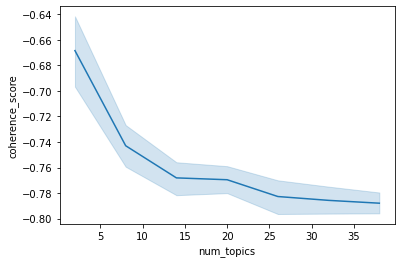

In [86]:
import seaborn as sns

ax = sns.lineplot(x="num_topics", y="coherence_score", data=topic_coherence);

In [87]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

NameError: name 'x' is not defined

---
---

## Challenge
### *Can we see if one of the authors focus more on men than women?*

*  Use Spacy for text prepocessing
*  Extract the Named Entities from the documents using Spacy (command is fairly straight forward)
*  Create unique list of names from the authors (you'll find that there are different types of named entities not all people)
*  Label the names with genders (can you this by hand or you use the US census name lists)
*  Customize your processing to replace the proper name with your gender from the previous step's lookup table
*  Then follow the rest of the LDA flow

In [78]:
import spacy

nlp = spacy.load('en_core_web_lg')

/Users/jonathansokoll/anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/thinc/neural/train.py:7: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from .optimizers import Adam, linear_decay
/Users/jonathansokoll/anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/thinc/check.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence, Sized, Iterable, Callable
/Users/jonathansokoll/anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/thinc/check.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence, Sized, Iterable, Callable


In [79]:
test = "Ned asked me a question about England today."

In [80]:
doc = nlp(test)

for token in doc:
    print(token.text, token.lemma_, token.pos_)

Ned Ned PROPN
asked ask VERB
me -PRON- PRON
a a DET
question question NOUN
about about ADP
England England PROPN
today today NOUN
. . PUNCT


In [81]:
for ent in doc.ents:
    print(ent.text, ent.label_)

Ned PERSON
England GPE
today DATE


In [82]:
def doc_stream(path):
    for f in os.listdir(path):
        with open(os.path.join(path,f)) as t:
            text = t.read().strip('\n')
            yield text

def get_people(docstream):
    
    ppl = []
    
    for d in docstream:
        
        doc = nlp(d)
        
        for ent in doc.ents:
            
            if ent.label_ == "PERSON":
                ppl.append(ent.lemma_)
                
    return set(ppl)

In [129]:
people = get_people(doc_stream(path))

In [126]:
doc = nlp(next(doc_stream(path)))

In [128]:
doc.ents[0].lemma_

'yesterday'

---
---

# Sources

### *References*
* [Andrew Ng et al paper on LDA](https://ai.stanford.edu/~ang/papers/jair03-lda.pdf)
* On [Coherence](https://pdfs.semanticscholar.org/1521/8d9c029cbb903ae7c729b2c644c24994c201.pdf)

### *Resources*

* [Gensim](https://radimrehurek.com/gensim/): Python package for topic modeling, nlp, word vectorization, and few other things. Well maintained and well documented.
* [Topic Modeling with Gensim](http://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#11createthedictionaryandcorpusneededfortopicmodeling): A kind of cookbook for LDA with gensim. Excellent overview, but the you need to be aware of missing import statements and assumed prior knowledge.
* [Chinese Restuarant Process](https://en.wikipedia.org/wiki/Chinese_restaurant_process): That really obscure stats thing I mentioned... 
* [PyLDAvis](https://github.com/bmabey/pyLDAvis): Library for visualizing the topic model and performing some exploratory work. Works well. Has a direct parrell implementation in R as well. 
* [Rare Technologies](https://rare-technologies.com/): The people that made & maintain gensim and a few other libraries.
* [Jane Austen v. Charlotte Bronte](https://www.literaryladiesguide.com/literary-musings/jane-austen-charlotte-bronte-different-alike/)